In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math 
import time
import cupy as cp

In [6]:
def hueShiftRed(r, g, b, h):
    U = math.cos(h * math.pi / 180)
    W = math.sin(h * math.pi / 180)

    r = (0.299 + 0.701 * U + 0.168 * W) * r
    g = (0.587 - 0.587 * U + 0.330 * W) * g
    b = (0.114 - 0.114 * U - 0.497 * W) * b
    return r,g,b
def normalizingInterval(normArray):
    high = 255
    low = 0
    maxDist = 0
    i=1
    for i in range(len(normArray)):
        dist =normArray[i] - normArray[i - 1]
        if dist > maxDist:
            maxDist = dist
            high = normArray[i]
            low = normArray[i - 1]
            
    return low, high

def compare(normArray):
    zero = np.zeros((len(normArray), len(normArray[0])))
    temp4 = np.maximum(normArray, zero)
    twofive = np.zeros((len(normArray), len(normArray[0])))
    twofive[twofive == 0] = 255
    temp5 = np.minimum(temp4, twofive)
    
    return temp5
    

C:\Users\cdrgv\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


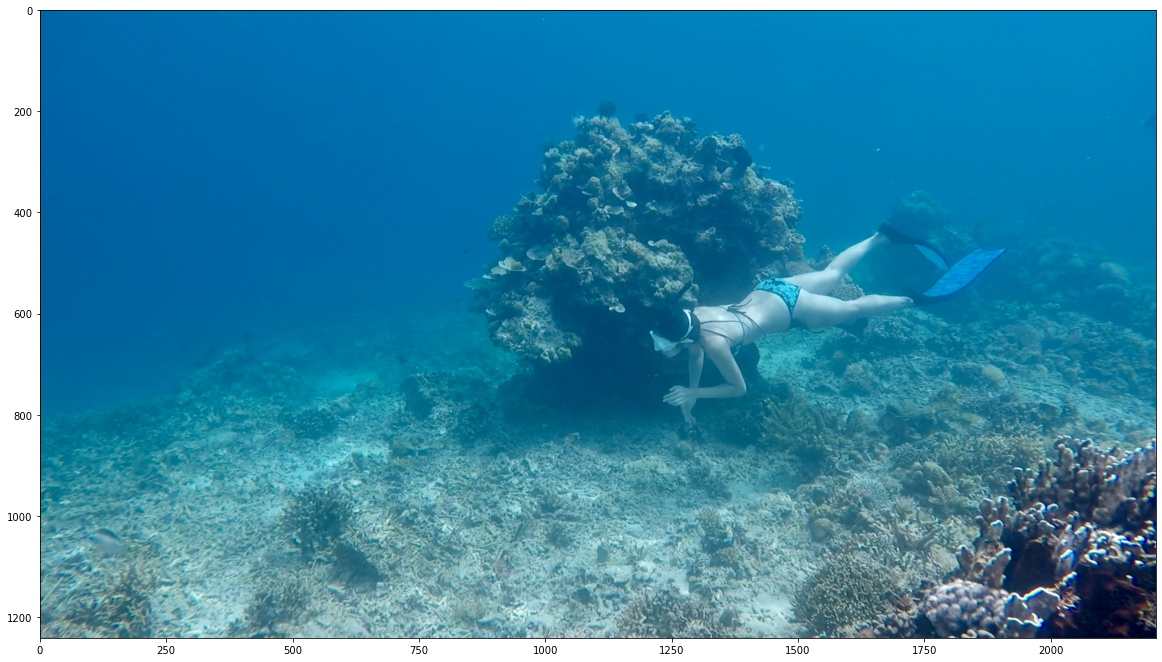

43.51362929999999


C:\Users\cdrgv\anaconda3\lib\site-packages\ipykernel_launcher.py:142: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


AttributeError: 'NoneType' object has no attribute 'seconds'

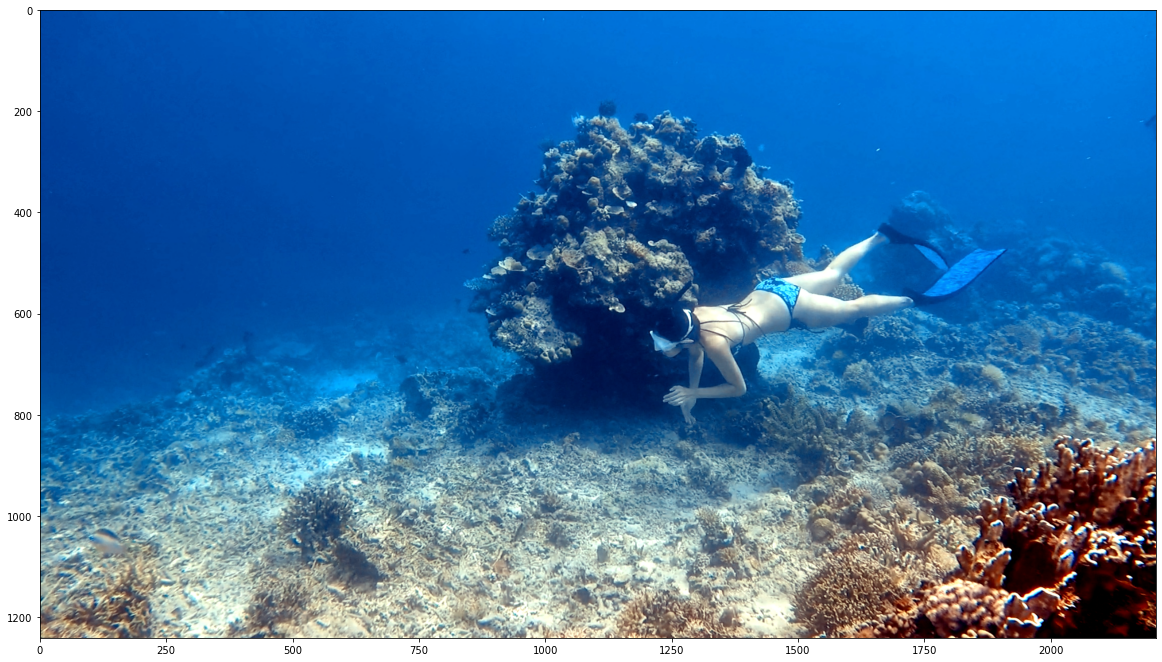

In [7]:

start = time.clock()

im1 = 'Data/3.jpg'

im1 = cv2.imread(im1)

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
# print(im1.shape)
width = (len(im1[0]))
height =(len(im1))
#calculate AverageColor

avg_color_per_row = np.average(im1, axis=0)
avg_color = np.average(avg_color_per_row, axis=0)

avg_r=avg_color[0]
avg_g=avg_color[1]
avg_b=avg_color[2]

#Calculate shift amount

hueShift = 0

newAvgRed = avg_r
minAvgRed = 60
maxHueShift = 120

while (newAvgRed < minAvgRed):
    shifted = hueShiftRed(avg_r, avg_g, avg_b, hueShift)
    newAvgRed = shifted[0] + shifted[1] + shifted[2]
    hueShift=hueShift+1
    if (hueShift > maxHueShift):
        newAvgRed = 60 

y=0
x=0

bgr_planes = cv2.split(im1)
r_ch = bgr_planes[2]
g_ch = bgr_planes[1]
b_ch = bgr_planes[0]
histr,histg,histb =[],[],[]
for i in range(256):
    histr.append(0)
    histg.append(0)
    histb.append(0)
for i in range(height):
    for j in range(width):
        red =round( r_ch[i][j])
        green =round( g_ch[i][j])
        blue  =round( b_ch[i][j])
        shifted = hueShiftRed(red , green , blue, hueShift)
        red = shifted[0] + shifted[1] + shifted[2]
        red = min(255, max(0, red))
        red = int(round(red))
        
        histr[red] += 1
        histg[green] += 1
        histb[blue] += 1
numOfPixels = width * height
thresholdRatio = 2000
thresholdLevel = numOfPixels / thresholdRatio

normalizer,normalizeg,normalizeb=[],[],[]

normalizer.append(0)
normalizeg.append(0)
normalizeb.append(0)

for i in range(256):
    if (histr[i]-thresholdLevel)<2:
        normalizer.append(i)
    if (histg[i]-thresholdLevel)<2:
        normalizeg.append(i)
    if (histb[i]-thresholdLevel)<2:
        normalizeb.append(i)
        
normalizer.append(255)
normalizeg.append(255)
normalizeb.append(255)

adjustr = normalizingInterval(normalizer)
adjustg = normalizingInterval(normalizeg)
adjustb = normalizingInterval(normalizeb)

blueMagicValue=1.2

shifted = hueShiftRed(1, 1, 1, hueShift)
redGain = 256 / (adjustr[1] - adjustr[0])
greenGain = 256 / (adjustg[1] - adjustg[0])
blueGain = 256 / (adjustb[1] - adjustb[0])

redOffset = (-adjustr[0] / 256) * redGain
greenOffset = (-adjustg[0] / 256) * greenGain
blueOffset = (-adjustb[0] / 256) * blueGain

adjstRed = shifted[0] * redGain
adjstRedGreen = shifted[1] * redGain
adjstRedBlue = shifted[2] * redGain * blueMagicValue


filter_=[adjstRed, adjstRedGreen, adjstRedBlue, 0, redOffset,
        0, greenGain, 0, 0, greenOffset,
        0, 0, blueGain, 0, blueOffset,
        0, 0, 0, 1, 0]
plt.figure(figsize=(20,20))
plt.imshow(im1)
plt.show()

newr= bgr_planes[2] * filter_[0] + bgr_planes[1]* filter_[1] + bgr_planes[0] * filter_[2] + filter_[4]* 225
newg=bgr_planes[1]* filter_[6] + filter_[9]* 225
newb=bgr_planes[0]* filter_[12] + filter_[14]* 225

for i in range(height):
    for j in range(width):

        newr[i][j]= min(255, max(0, newr[i][j]))
        newg[i][j]= min(255, max(0, newg[i][j]))
        newb[i][j]= min(255, max(0, newb[i][j]))


# newr = newr.astype(bgr_planes[2].dtype)
# newg = newr.astype(bgr_planes[1].dtype)
# newb = newr.astype(bgr_planes[0].dtype)
# newr = newr/(newr.max()/255.0)
# newg = newg/(newg.max()/255.0)
# newb = newb/(newb.max()/255.0)

new = cv2.merge((newb.astype(bgr_planes[0].dtype),newg.astype(bgr_planes[0].dtype),newr.astype(bgr_planes[1].dtype)))  
# plt.figure(figsize=(20,20))
# plt.imshow(new)
# plt.savefig('out.png', bbox_inches='tight', pad_inches=0)
# plt.show()

plt.figure(figsize=(20,20))
fig = plt.imshow(new)
# plt.axis('off')
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# plt.savefig('pict.png', bbox_inches='tight', pad_inches = 0)

end = time.clock()
print (end - start)

In [42]:
t1 = time.time()

im1 = 'Data/3.jpg'

im1 = cv2.imread(im1)

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
# print(im1.shape)
width = (len(im1[0]))
height =(len(im1))
#calculate AverageColor

avg_color_per_row = np.average(im1, axis=0)
avg_color = np.average(avg_color_per_row, axis=0)

avg_r=avg_color[0]
avg_g=avg_color[1]
avg_b=avg_color[2]

#Calculate shift amount

hueShift = 0

newAvgRed = avg_r
minAvgRed = 60
maxHueShift = 120

while (newAvgRed < minAvgRed):
    shifted = hueShiftRed(avg_r, avg_g, avg_b, hueShift)
    newAvgRed = shifted[0] + shifted[1] + shifted[2]
    hueShift=hueShift+1
    if (hueShift > maxHueShift):
        newAvgRed = 60 

y=0
x=0

bgr_planes = cv2.split(im1)
r_ch = bgr_planes[2]
g_ch = bgr_planes[1]
b_ch = bgr_planes[0]


temp = hueShiftRed(r_ch , g_ch , b_ch, hueShift) 
temp2 =temp[0]+temp[1]+temp[2]
temp6 = np.round(compare(temp2), 0)
unique, counts = np.unique(temp6, return_counts=True)
histr=dict(zip(unique, counts))

unique, counts = np.unique(np.round(g_ch, 0), return_counts=True)
histg=dict(zip(unique, counts))

unique, counts = np.unique(np.round(b_ch, 0), return_counts=True)
histb=dict(zip(unique, counts))



numOfPixels = width * height
thresholdRatio = 2000
thresholdLevel = numOfPixels / thresholdRatio

normalizer,normalizeg,normalizeb=[],[],[]

normalizer.append(0)
normalizeg.append(0)
normalizeb.append(0)

for i in range(256):
    if (histr[i]-thresholdLevel)<2:
        normalizer.append(i)
    if (histg[i]-thresholdLevel)<2:
        normalizeg.append(i)
    if (histb[i]-thresholdLevel)<2:
        normalizeb.append(i)
        
normalizer.append(255)
normalizeg.append(255)
normalizeb.append(255)

adjustr = normalizingInterval(normalizer)
adjustg = normalizingInterval(normalizeg)
adjustb = normalizingInterval(normalizeb)

blueMagicValue=1.2

shifted = hueShiftRed(1, 1, 1, hueShift)
redGain = 256 / (adjustr[1] - adjustr[0])
greenGain = 256 / (adjustg[1] - adjustg[0])
blueGain = 256 / (adjustb[1] - adjustb[0])

redOffset = (-adjustr[0] / 256) * redGain
greenOffset = (-adjustg[0] / 256) * greenGain
blueOffset = (-adjustb[0] / 256) * blueGain

adjstRed = shifted[0] * redGain
adjstRedGreen = shifted[1] * redGain
adjstRedBlue = shifted[2] * redGain * blueMagicValue


filter_=[adjstRed, adjstRedGreen, adjstRedBlue, 0, redOffset,
        0, greenGain, 0, 0, greenOffset,
        0, 0, blueGain, 0, blueOffset,
        0, 0, 0, 1, 0]
# plt.figure(figsize=(20,20))
# plt.imshow(im1)
# plt.show()

newr= compare(bgr_planes[2] * filter_[0] + bgr_planes[1]* filter_[1] + bgr_planes[0] * filter_[2] + filter_[4]* 225)
newg=compare(bgr_planes[1]* filter_[6] + filter_[9]* 225)
newb=compare(bgr_planes[0]* filter_[12] + filter_[14]* 225)


new = cv2.merge((newb.astype(bgr_planes[0].dtype),newg.astype(bgr_planes[0].dtype),newr.astype(bgr_planes[1].dtype)))  

# plt.figure(figsize=(20,20))
# fig = plt.imshow(new)
# plt.axis('off')
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# plt.savefig('pict.png', bbox_inches='tight', pad_inches = 0)

t2 = time.time()
print('time elapsed: ' + str(round(t2-t1, 2)) + ' seconds')

time elapsed: 0.57 seconds


In [43]:
t1 = time.time()


im1 = 'Data/3.jpg'

im1 = cv2.imread(im1)

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
# print(im1.shape)
width = (len(im1[0]))
height =(len(im1))
#calculate AverageColor

avg_color_per_row = cp.average(im1, axis=0)
avg_color = cp.average(avg_color_per_row, axis=0)

avg_r=avg_color[0]
avg_g=avg_color[1]
avg_b=avg_color[2]

#Calculate shift amount

hueShift = 0

newAvgRed = avg_r
minAvgRed = 60
maxHueShift = 120

while (newAvgRed < minAvgRed):
    shifted = hueShiftRed(avg_r, avg_g, avg_b, hueShift)
    newAvgRed = shifted[0] + shifted[1] + shifted[2]
    hueShift=hueShift+1
    if (hueShift > maxHueShift):
        newAvgRed = 60 

y=0
x=0

bgr_planes = cv2.split(im1)
r_ch = bgr_planes[2]
g_ch = bgr_planes[1]
b_ch = bgr_planes[0]


temp = hueShiftRed(r_ch , g_ch , b_ch, hueShift) 
temp2 =temp[0]+temp[1]+temp[2]
temp6 = cp.around(compare(temp2), 0)
unique, counts = cp.unique(temp6, return_counts=True)
histr=dict(zip(cp.asnumpy(unique), cp.asnumpy(counts)))

unique, counts = cp.unique(cp.around(g_ch, 0), return_counts=True)
histg=dict(zip(cp.asnumpy(unique), cp.asnumpy(counts)))

unique, counts = cp.unique(cp.around(b_ch, 0), return_counts=True)
histb=dict(zip(cp.asnumpy(unique), cp.asnumpy(counts)))



numOfPixels = width * height
thresholdRatio = 2000
thresholdLevel = numOfPixels / thresholdRatio

normalizer,normalizeg,normalizeb=[],[],[]

normalizer.append(0)
normalizeg.append(0)
normalizeb.append(0)

for i in range(256):
    if (histr[i]-thresholdLevel)<2:
        normalizer.append(i)
    if (histg[i]-thresholdLevel)<2:
        normalizeg.append(i)
    if (histb[i]-thresholdLevel)<2:
        normalizeb.append(i)
        
normalizer.append(255)
normalizeg.append(255)
normalizeb.append(255)

adjustr = normalizingInterval(normalizer)
adjustg = normalizingInterval(normalizeg)
adjustb = normalizingInterval(normalizeb)

blueMagicValue=1.2

shifted = hueShiftRed(1, 1, 1, hueShift)
redGain = 256 / (adjustr[1] - adjustr[0])
greenGain = 256 / (adjustg[1] - adjustg[0])
blueGain = 256 / (adjustb[1] - adjustb[0])

redOffset = (-adjustr[0] / 256) * redGain
greenOffset = (-adjustg[0] / 256) * greenGain
blueOffset = (-adjustb[0] / 256) * blueGain

adjstRed = shifted[0] * redGain
adjstRedGreen = shifted[1] * redGain
adjstRedBlue = shifted[2] * redGain * blueMagicValue


filter_=[adjstRed, adjstRedGreen, adjstRedBlue, 0, redOffset,
        0, greenGain, 0, 0, greenOffset,
        0, 0, blueGain, 0, blueOffset,
        0, 0, 0, 1, 0]
# plt.figure(figsize=(20,20))
# plt.imshow(im1)
# plt.show()

newr= compare(bgr_planes[2] * filter_[0] + bgr_planes[1]* filter_[1] + bgr_planes[0] * filter_[2] + filter_[4]* 225)
newg=compare(bgr_planes[1]* filter_[6] + filter_[9]* 225)
newb=compare(bgr_planes[0]* filter_[12] + filter_[14]* 225)


new = cv2.merge((newb.astype(bgr_planes[0].dtype),newg.astype(bgr_planes[0].dtype),newr.astype(bgr_planes[1].dtype)))  

# plt.figure(figsize=(20,20))
# fig = plt.imshow(new)
# plt.axis('off')
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# plt.savefig('pict.png', bbox_inches='tight', pad_inches = 0)

t2 = time.time()
print('time elapsed: ' + str(round(t2-t1, 2)) + ' seconds')

time elapsed: 0.26 seconds


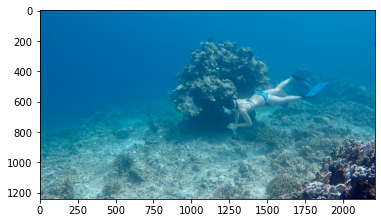

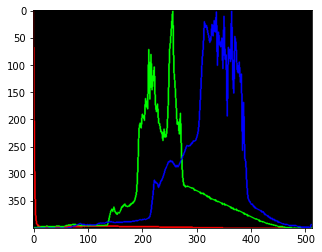

In [33]:
bgr_planes = cv2.split(im1)
histSize = 256
histRange = (0, 256) # the upper boundary is exclusive
accumulate = False
b_hist = cv2.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
g_hist = cv2.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
r_hist = cv2.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)
hist_w = 512
hist_h = 400
bin_w = int(round( hist_w/histSize ))
histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
cv2.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
cv2.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
cv2.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
for i in range(1, histSize):
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(np.round(b_hist[i-1])) ),
            ( bin_w*(i), hist_h - int(np.round(b_hist[i])) ),
            ( 255, 0, 0), thickness=2)
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(np.round(g_hist[i-1])) ),
            ( bin_w*(i), hist_h - int(np.round(g_hist[i])) ),
            ( 0, 255, 0), thickness=2)
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(np.round(r_hist[i-1])) ),
            ( bin_w*(i), hist_h - int(np.round(r_hist[i])) ),
            ( 0, 0, 255), thickness=2)
# plt.figure(figsize=(20,20))
plt.imshow(im1)
plt.show()
# cv.imshow('Source image', im1)
# plt.figure(figsize=(20,20))
plt.imshow(histImage)
plt.show()
# cv.imshow('calcHist Demo', histImage)

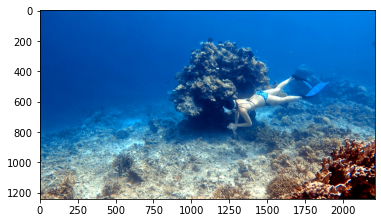

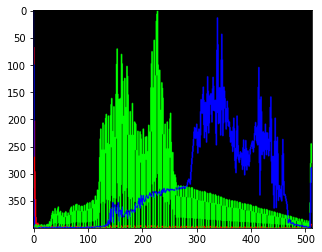

In [34]:
bgr_planes = cv2.split(new)
histSize = 256
histRange = (0, 256) # the upper boundary is exclusive
accumulate = False
b_hist = cv2.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
g_hist = cv2.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
r_hist = cv2.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)
hist_w = 512
hist_h = 400
bin_w = int(round( hist_w/histSize ))
histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
cv2.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
cv2.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
cv2.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv2.NORM_MINMAX)
for i in range(1, histSize):
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(np.round(b_hist[i-1])) ),
            ( bin_w*(i), hist_h - int(np.round(b_hist[i])) ),
            ( 255, 0, 0), thickness=2)
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(np.round(g_hist[i-1])) ),
            ( bin_w*(i), hist_h - int(np.round(g_hist[i])) ),
            ( 0, 255, 0), thickness=2)
    cv2.line(histImage, ( bin_w*(i-1), hist_h - int(np.round(r_hist[i-1])) ),
            ( bin_w*(i), hist_h - int(np.round(r_hist[i])) ),
            ( 0, 0, 255), thickness=2)
# plt.figure(figsize=(20,20))
plt.imshow(new)
plt.show()
# cv.imshow('Source image', im1)
# plt.figure(figsize=(20,20))
plt.imshow(histImage)
plt.show()
# cv.imshow('calcHist Demo', histImage)